# Illustrate theoretical discernability and accuracy of CRNS signal of a directional CRNS probe
Scripts for generating the figures of the manuscript
"Assessing the feasibility of a directional CRNS-sensor for estimating soil moisture"
by Till Francke, Maik Heistermann, Markus Köhli, Christian Budach, Martin Schrön, Sascha E. Oswald

## 0. parameters ####
This chunk contains the parameters of the simulation, or lets you choose the pre-defined scenarios "bestcase" and "worstcase".

In [18]:
# set the scenario of interest here:
#scenario="bestcase" #"bestcase" or "worstcase"
scenario="worstcase" #"bestcase" or "worstcase"

library(latex2exp)

R_1  = 2100 #base count rate of area_1 [counts per hour]
# contrast = 0.5  #relative difference in countrate in area_2 [-] #for example figure CI
contrast = 0.2  #relative difference in countrate in area_2 [-] #for example figure CI

R_2 = R_1 * (1+contrast)


if (scenario == "bestcase")
{
  # snr = 2.63 #bestcase detector #signal-noise-ratio of targeted to untargeted area (from Markus' simulations)
  eps = 0.1 #bestcase ## fraction of non-epithermal neutrons in counts (=noise)
  gamma_dir = 0.2 #fraction of non-albedo counts in the directional signal
  eta = 0.72 #collimation efficiency
  beta = 0.4 #fraction of total counts after installing the collimator
  
} else
  if (scenario == "worstcase")
  {
    #snr = 1.57 #actual detector #signal-noise-ratio of targeted to untargeted area (from Markus' simulations)
    eps = 0.3 #worstcase # fraction of non-epithermal neutrons in counts (=noise)
    gamma_dir = 0.31 #fraction of non-albedo counts in the directional signal
    eta = 0.61 #collimation efficiency
    beta = 0.3 #fraction of total counts after installing the collimator
  } else
  { #idealistic scenario (testing only)
    eps = 0.0  #fraction of non-epithermal neutrons in counts (=noise)
    gamma_dir = 0. #fraction of non-albedo counts in the directional signal
    eta = 0.7 #collimation efficiency
    beta = 1 #fraction of total counts after installing the collimator
  } 
gamma_no = 0.17 #fraction of non-albedo counts in the non-directional signal (0.13 - 0.26)

#A = rbind(c(snr,1), c(1, snr)) / (1+snr) #for converting N1 and N2 to Nf1 and Nf2
A = rbind(c(eta,1-eta), c(1-eta, eta))  #for converting N1 and N2 to Nf1 and Nf2

B =  A*(beta-beta*gamma_dir) + 1/2*beta*gamma_dir
#library(matlib)
#Ai = inv(A) #for converting Nf1 and Nf2 to N1 and N2
#Bi = inv(B) #for converting N_f to N_total
#using analytical inversion of matrix:
k_1 = 2 * beta * (2 * gamma_dir*eta - gamma_dir  - 2*eta + 1) 
k_2=(2 * gamma_dir * eta - gamma_dir- 2 * eta)
Bi = 1/k_1 * rbind(c(k_2, k_2+2), c(k_2+2, k_2))  #for converting N_total to N_f

delta_t = 1 # interval for aggregating the counts [h]
p_thresh = 0.05 #threshold p-value
precision = 0.05 #threshold for width of confidence interval of a rate, relative to true rate
#ratio_precision = 0.1 #threshold for width of confidence interval of estimated ratio between two rates, relative to true ratio of rates

#selection of ranges in plots

#count rates to analyse
#R_coarse = c(450, 2100, 8000, 39000, 144000)
R_coarse = c(500, 2000, 8000, 40000, 150000) #Martin's suggestion
R_fine   = exp(seq(from=log(min(R_coarse)), to = log(max(R_coarse)), length.out = 100))

#aggregation intervals rates to analyse
delta_ts_coarse = c(1, 6, 12, 24, 48)
delta_ts_fine = exp(seq(from=log(min(delta_ts_coarse)), to=log(max(delta_ts_coarse+2)), length.out=200))  #aggregation intervals to test [h]

contrasts_coarse = c(.2, .5, .8, 1.4 )
contrasts_fine = exp(seq(from=log(min(contrasts_coarse)), to=log(max(contrasts_coarse)), length.out=100))  #contrasts to test [-]


#plotting parameters
save_plots = FALSE #enable/disable saving PDFs (must be disabled to run in mybinder)                    
linetypes=c(bestcase="solid", worstcase="dashed") #linetypes for plots

#wrapper for savePlot to handle saving plots differently (when run as notebook OR for producing file output)
savePlot2 = function(...)
{
  if (names(dev.cur())!="RStudioGD" & save_plots) #if this is an RStudio-Plot, don't save
    savePlot(...)
}

#create list for displaying both scenarios when run again
if (!exists("results")) results=list() #create list, if not existing

source("R/compute_ci_p.R")

# 0 compute the max/min requirements for the specified singular settings
#searching to fulfill CI requirements
#a) required rate for 24 h
optimize(interval = range(R_coarse),        difference_to_threshold_ci, delta_t=24, contrast=contrast,          B=B, Bi=Bi, target_sensor="R_1r_t", precision=precision)
#b) required min aggregation interval
optimize(interval = range(delta_ts_coarse), difference_to_threshold_ci,             contrast=contrast, R_1=R_1, B=B, Bi=Bi, target_sensor="R_1r_t", precision=precision)
#c) max contrast interval for 24 h
optimize(interval = range(contrasts_coarse), difference_to_threshold_ci, delta_t=24,                    R_1=R_1, B=B, Bi=Bi, target_sensor="R_1r_t", precision=precision)

#searching to fulfill p-value requirements
#d) required rate for 24 h
optimize(interval = range(R_coarse),        difference_to_threshold_p, delta_t=24, contrast=contrast,          B=B, Bi=Bi, target_comparison="N_1r_t.N_2r_t", p_thresh=p_thresh)
#e) required min aggregation interval
optimize(interval = range(delta_ts_coarse), difference_to_threshold_p,             contrast=contrast, R_1=R_1, B=B, Bi=Bi, target_comparison="N_1r_t.N_2r_t", p_thresh=p_thresh)
#f) min contrast interval resolvable for 1 h resolution
optimize(interval = range(contrasts_coarse), difference_to_threshold_p, delta_t=1 ,                    R_1=R_1, B=B, Bi=Bi, target_comparison="N_1r_t.N_2r_t", p_thresh=p_thresh)
#g) min contrast interval resolvable for 24 h resolution
optimize(interval = range(contrasts_coarse), difference_to_threshold_p, delta_t=24,                    R_1=R_1, B=B, Bi=Bi, target_comparison="N_1r_t.N_2r_t", p_thresh=p_thresh)


$minimum
[1] 20759

$objective
           R_1r_t 
0.000000004048873

$minimum
[1] 47.97262

$objective
    R_1r_t 
0.06118318

$minimum
[1] 0.2000793

$objective
   R_1r_t 
0.1072082

$minimum
[1] 651.4429

$objective
N_1r_t.N_2r_t 
0.00001050165

$minimum
[1] 7.445379

$objective
N_1r_t.N_2r_t 
0.00001050165

$minimum
[1] 0.5925283

$objective
 N_1r_t.N_2r_t 
0.000007191306

$minimum
[1] 0.2000793

$objective
N_1r_t.N_2r_t 
   0.04956919

## 1. simulate  for a single setting ####

In [19]:

res2 = t(sapply(X=delta_ts_fine, FUN=compute_ci_p2, R_1=R_1, R_2=R_2, B=B, Bi=Bi, eps=eps))

#convert to match conventions of plotting routine
tt = c(R_1, R_2, c(R_1, R_2) %*% B) #all four count rates
R = t(array(data=tt, dimnames = list(c("R_1", "R_2", "R_f1", "R_f2")))) #count rates [counts per hour]
R = c( R, R * (1-eps)) #these are the total ("_t") and epithermal ("_epi") rates
names(R) = paste0(c("R_1", "R_2", "R_f1", "R_f2"), c(rep("_t",4), rep("_epi",4)))

ci_cols = grep(dimnames(res2)[[2]], pattern = "R_", value = TRUE) #get the names of the rates contained
ci_lohi =   array(NA, c(length(delta_ts_fine), length(ci_cols), 2), dimnames = list(NULL, ci_cols, c("lo", "hi"))) #confidence intervals of measurements

ci_lohi[,,"lo"] = res2[, ci_cols]
ci_lohi[,,"hi"] = t(2 *R[sub(ci_cols, pattern = "(\\d)r_", repl="\\1_")] - t(res2[, ci_cols])  ) #just the symetric other side
p_value_comp    = res2[, !(dimnames(res2)[[2]] %in% ci_cols)]
#str(res2)


This chunk does the computations for the following two plots.

## 1.1 plot counts and CIs (fig. 7 / ci_example) ####

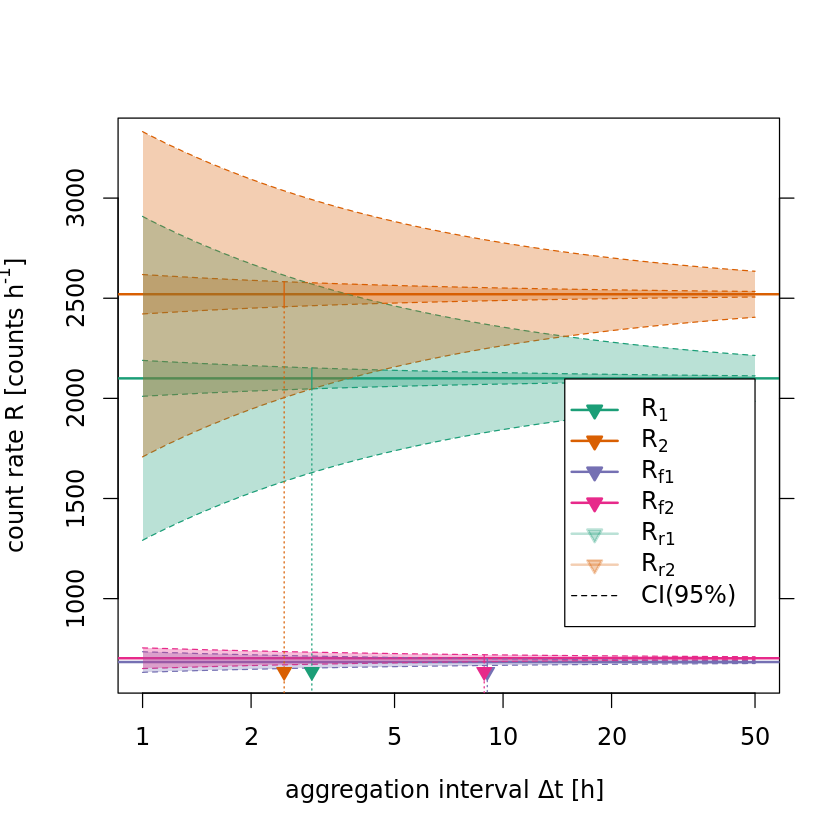

In [20]:

if (save_plots) x11()
par(cex=1.2)

#CI
#cols2plot  = 1:NCOL(ci_lohi)
#ncols2plot = NCOL(ci_lohi)

#plot CI as lines
cols2plot =  c("R_1_t", "R_2_t", "R_f1_t", "R_f2_t",  "R_1r_t",  "R_2r_t") #columns containing the "_t" (total) values

ncols2plot = length(cols2plot)

library(RColorBrewer)
n = ncols2plot - 2 #the two reconstructed will recycle the colours
#construct palette
palette(brewer.pal(n=n, "Dark2"))

ylims = pmax(0, range(ci_lohi[-(1:5), cols2plot,])) #discard the very wide interval in the first three rows
ylims[2] = max(ylims[2], max (R)) #accommodate largest rate in plot
#ylims = c(1800, 2500)

xlims = range(delta_ts_fine)

plot(1, type="n",
     ylim=ylims, xlim=xlims, ylab = TeX("count rate R \\[counts h^{-1}\\]"), xlab=expression(paste("aggregation interval ", Delta, "t [h] ")), log="x")

#plot counts
abline(h= R[  1:4 ], col=1:4, lty=1, lwd=2) #the "_t" rates
#abline(h= R[-(1:4)], col=1:4, lty="dashed", lwd=2) #the "_epi" rates


lwd = 1
#lty = ifelse(grepl(cols2plot, pattern = "\\dr_"), "dotted", "dotdash")
lty = "dashed"

matplot(delta_ts_fine, y= ci_lohi[, cols2plot,"hi"], type="l", add = TRUE,
        col=1:(ncols2plot-2), lty=lty, lwd=lwd)
matplot(delta_ts_fine, y= ci_lohi[, cols2plot,"lo"], type="l", add = TRUE,
        col=1:(ncols2plot-2), lty=lty, lwd=lwd)


#plot CIs as envelopes
org_cols = palette() #store original palette
transp_cols <- adjustcolor(org_cols, alpha.f = 0.3) #set transparency (for plotting envelopes)
palette(transp_cols)

for (i in 1:ncols2plot) #plot envelopes for increased visibility
  polygon(c(delta_ts_fine, rev(delta_ts_fine)), 
          c(ci_lohi[,cols2plot[i],"hi"],rev(ci_lohi[,cols2plot[i],"lo"])), border = NA, col = i)
palette(org_cols)

ci_range = apply(ci_lohi[, cols2plot,], MAR=c(1,2), diff)   

ref_cols = sub(cols2plot, pattern = "(\\d)r_", repl="\\1_") #the columns containing the respective count rates

within_precision = t(t(ci_range) / R[ref_cols]) <= precision #check, where the CI is smaller than the chosen precision
min.which = function(x){ifelse(any(x), min(which(x)), NA)}
min_delta_t = apply(within_precision, MAR=2, FUN=min.which) #get indices to times when error falls below threshold
for (i in 1:ncols2plot) #plot lines denoting minimum aggregation interval
{  
  if(grepl(cols2plot[i], pattern = "\\dr_"))
     {
       linecol=transp_cols[i - ncols2plot+2]
       fillcol= linecol
     }   else
     {
       linecol= org_cols[i]
       fillcol= linecol
     }
             
  xplot = delta_ts_fine[min_delta_t[i]] #find position of x-axis where to plot the line
  lines(rep(xplot,2),  ci_lohi[min_delta_t[i], cols2plot[i],], col=linecol) #plot line illustrating the width of the interval
  lines(rep(xplot,2),  c(ci_lohi[min_delta_t[i], cols2plot[i],"lo"], 0), col=linecol, lty="dotted")  #plot line pointing down to the x-axis
  #points(xplot,  R[i], col=i, pch=25, crt=180 ) 
  points(xplot,  ylims[1], col=linecol, pch=25, bg=fillcol) #plot marker at x-axis
}          
axis(side=4, labels=FALSE)
legend_str = sapply(FUN = TeX, X =  c("R_1", "R_2", "R_{f1}", "R_{f2}", "R_{r1}", "R_{r2}", "CI(95%)"))
legend(x=xlims[2], y=c(0.45, 0.55) %*% ylims, xjust=1, legend=legend_str, 
       lty=c(rep("solid",6), "dashed"),
       pch=c(rep(25,6),NA),
       col=c(org_cols[1:4], transp_cols[1:2], "black"), 
       pt.bg = c(org_cols[1:4], transp_cols[1:2], "black"), 
       lwd=c(rep(2,6), 1), ncol=1, bg="white")



savePlot2(filename = paste0("ci_examp_", scenario,".png"), type = "png")

if (Sys.info()["sysname"]=="Windows") #pdf-export only works in Windows
  savePlot2(filename = paste0("ci_examp_", scenario,".pdf"), type = "pdf")


Example for 95 \%-confidence intervals for the count rates obtained within the half-spaces (${R}_\text{1,total}$ = 2100 counts/h, ${R}_\text{2,total}$ = 2520 counts/h, "bestcase scenario", moderate contrast $\Delta R=0.2$), by the directional CRNS-sensors (${R}_\text{f1,total}$, ${R}_\text{f2,total}$) and the rates reconstructed from the directional sensors (${R}_\text{1r,total}$, ${R}_\text{2r, total}$). The vertical arrows indicate the minimum required aggregation time to confine the CI within 5 \% of the true value ($\Delta t_\text{min}^{\text{determ}}$).

## 1.2 p-values of comparison (fig. 8 / p_example)####

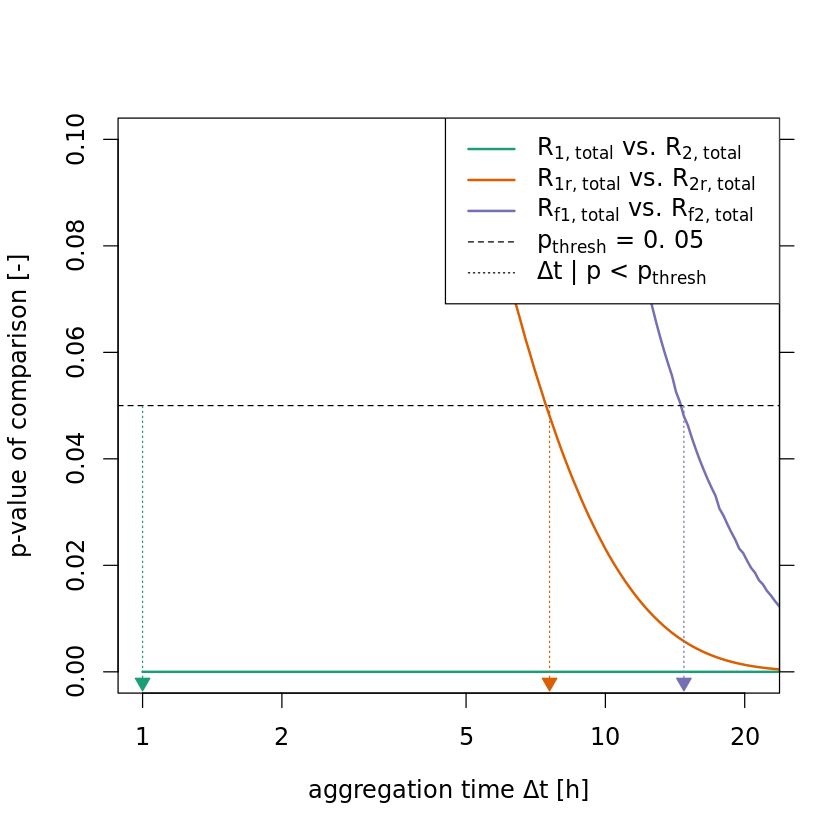

In [21]:

if (save_plots) x11()
par(cex=1.2)
#cols2plot =  dimnames(p_value_comp)[[2]]
cols2plot = c("N_1_t.N_2_t", "N_1r_t.N_2r_t", "N_f1_t.N_f2_t") #, "N_f1_t.N_f2_t"

ncols2plot = length(cols2plot)
#ylims = range(p_value_comp[-(1:5), cols2plot]) 
ylims=c(0, 0.1)

library(RColorBrewer)
palette(brewer.pal(n=ncols2plot, "Dark2")) #construct palette

ix_min_below_thresh = apply(p_value_comp, MAR=2, FUN=function(x){which(x <= p_thresh)[1]}) #find position, beyond which the p-value is lower than the specified threshold

delta_t_subs = 1:min(max(ix_min_below_thresh, length(delta_ts_fine)/2), length(delta_ts_fine))

matplot(delta_ts_fine, y= p_value_comp[, cols2plot], type="l",
        ylim=ylims, xlim=range(delta_ts_fine[delta_t_subs]), ylab = "p-value of comparison [-]", xlab=expression(paste("aggregation time ", Delta, "t [h]")),
        col=1:ncols2plot, lty=1, lwd=2, log="x")
abline(h=p_thresh, lty="dashed")

#find indices, after which the p-value is below the threshold
#abline(v=delta_ts_fine[ix_min_below_thresh[cols2plot]], col=1:ncols2plot, lty="dotted")
for (i in 1:ncols2plot)
{  
  xplot = delta_ts_fine[ix_min_below_thresh[cols2plot[i]]]
  lines(rep(xplot,2), c(-0.002, p_thresh), col=i, lty="dotted")
  points(xplot,  -0.002, col=i, pch=25, bg=i) 
}

cols2plot_l = gsub(x=cols2plot  , pattern="_epi", repl=",epi")
cols2plot_l = gsub(x=cols2plot_l, pattern="_t", repl=",total")
cols2plot_l = gsub(x=cols2plot_l, pattern="_([^\\.]*)", repl="_{\\1}")
cols2plot_l = gsub(x=cols2plot_l, pattern="\\.", repl=" vs. ")
cols2plot_l = gsub(x=cols2plot_l, pattern="N", repl="R")

axis(side=4, labels=FALSE)
legend_str = sapply(FUN = TeX, X =  c(cols2plot_l, "p_{thresh} = 0.05",  paste0("$\\Delta t$ | p < p_{thresh}")))
legend("topright", legend=legend_str, 
       lty=c(rep("solid", ncols2plot), "dashed", "dotted"),
       lwd = c(rep(2, ncols2plot), 1, 1) ,
       col=c(palette()[1:ncols2plot],"black","black"),
       bg="white" )
savePlot2(filename =  paste0("p_value_examp_", scenario,".png"), type = "png")

if (Sys.info()["sysname"]=="Windows") #pdf-export only works in Windows
  savePlot2(filename = paste0("p_value_examp_", scenario,".pdf"), type = "pdf")


p-values for discriminating pairs of measured count rates (${R}_\text {1,total}$ = 2100 counts/h, ${R}_\text {2,total}$ = 2520  counts/h, "bestcase scenario", moderate contrast $\Delta R=0.2$). The vertical arrows indicate the minimum required aggregation time $\Delta t_\text{min}^{\text{disting}}$ to statistically \emph{distinguish} two rates at p = 0.05.

# Simulations for a range of settings 
## 2.1 simulate  for a range of settings: R vs. t_min (CI-thresh) ####

In [22]:

# requires functions p_value_two_sided() and compute_ci_p2()


delta_ts_fine = exp(seq(from=log(0.5), to=log(30), length.out=100))  #aggregation intervals to test [h]


# find the minimum required aggregation time for the CI to fall below specified precision
find_min_aggr_time_ci = function(R_1, contrast,  B,  Bi, target_sensor, precision) 
{  
  res = optimize(interval = c(0.0, 1000), difference_to_threshold_ci, R_1=R_1, contrast=contrast, B=B, Bi=Bi, target_sensor=target_sensor, precision=precision)
  return(res$minimum)
}

#
#difference_to_threshold_ci(delta_t, R_1, contrast=contrast,  B,  Bi, target_sensor="R_1r_epi", precision) 
#compute_ci_p2(delta_t = delta_t, R_1=R_1, R_2=R_1*(1+con), B=B, Bi=Bi, eps=eps)  

collected_min_aggr_time = array(NA, dim=c(length(contrasts_coarse), length(R_fine)))
for (i in 1:length(contrasts_coarse))
{
  contrast = contrasts_coarse[i]
  collected_min_aggr_time[i,] = sapply(X=R_fine, FUN=find_min_aggr_time_ci, contrast=contrast, B=B, Bi=Bi, target_sensor="R_1r_t", precision=precision, simplify = TRUE)
}

#store results for displaying both scenarios when run again
results[["f2_1"]][scenario]=list(collected_min_aggr_time)

## 2.1 plot results (fig. 9) ####

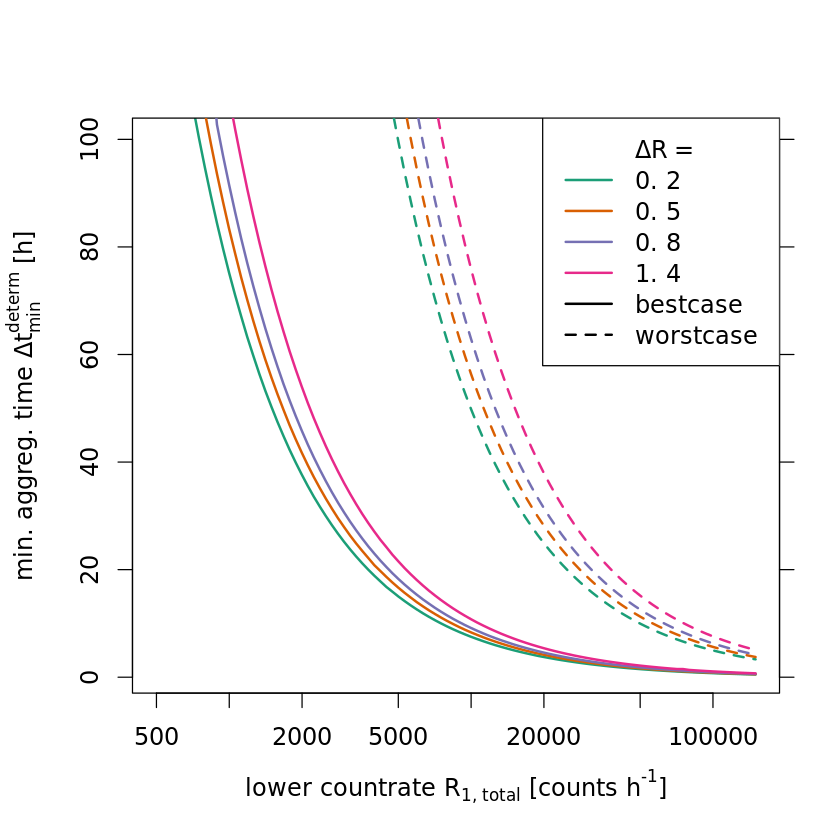

In [23]:

library(RColorBrewer)
palette(brewer.pal(n=nrow(collected_min_aggr_time), "Dark2")) #construct palette
# if (save_plots) x11(width=8, height=4)
# par(mar=par("mar") + c(0, 0.5,-3,0), cex=1.2, oma=c(0,0,0,0))
if (save_plots) x11()
par(mar=par("mar") + c(0, 0.5, 0,0), cex=1.2)


ylims=c(1,100)

options(scipen=5) #prevent scientific notation in log-scale of plot
scens2plot = names(results[["f2_1"]]) #get scenarios available in results
for (scen2plot in scens2plot)
{
  collected_min_aggr_time = results[["f2_1"]][[scen2plot]]
  matplot(R_fine, y= t(collected_min_aggr_time), type="l", log="x",
          ylim=ylims,
          xlab=TeX("lower countrate R_{1,total} \\[counts h^{-1}\\]"), 
          ylab=TeX("min. aggreg. time  $\\Delta t_{min}^{determ}$ \\[h\\]"),
          #main=scenario,
          col=1:4, lwd=2,
          lty=linetypes[scen2plot],
          add=ifelse(scen2plot == scens2plot[1], FALSE, TRUE))
}
  
#text(x = exp(mean(log(range(R_fine)))), y=0.9 * max(ylims), labels = paste0("\"", scenario, "\""), cex = 1.2)

axis(side=4, labels=FALSE)
legend_str = sapply(FUN = TeX, X =  c("$\\Delta R$=", paste0(contrasts_coarse, "")))
legend_str = c(legend_str, scens2plot)
legend("topright", legend=legend_str, 
       col=c(NA, palette()[ 1:length(contrasts_coarse)], rep("black", length(scens2plot))),
       lty=c(NA, rep("solid", length(contrasts_coarse)), linetypes[scens2plot]), lwd=2)
savePlot2(filename =  paste0("A1_CI_R_vs_aggrtime_", scenario,".png"), type = "png")
if (Sys.info()["sysname"]=="Windows") #pdf-export only works in Windows
  savePlot2(filename = paste0("A1_CI_R_vs_aggrtime_", scenario,".pdf"), type = "pdf")


Minimum aggregation time $\Delta t_\text{min}^{\text{determ}}$ required to obtain the reconstructed count rate ${R}_\text{1r}$ from the two directional measurements with a CI smaller than 5 \% of the actual value.

## 2.2 simulate for a range of settings: R vs. t_min (p-thresh) ####

In [24]:

# requires functions p_value_two_sided() and compute_ci_p2()

#delta_ts_fine = exp(seq(from=log(0.5), to=log(30), length.out=100))  #aggregation intervals to test [h]




# find the minimum required aggregation time for the p-value to fall below specified p_thresh
find_min_aggr_time_p = function(R_1, contrast,  B,  Bi, target_comparison, p_thresh) 
{  
  minv = optimize(interval = c(0.01, 48), difference_to_threshold_p, R_1=R_1, contrast=contrast, B=B, Bi=Bi, target_comparison="N_1r_t.N_2r_t", p_thresh=p_thresh)$minimum
  return(minv)
}

#minimum aggregation time required for example setting 
#(delta_t = find_min_aggr_time_p(R_1 = R_1, contrast=contrast, B=B, Bi=Bi, target_comparison="N_1r_t.N_2r_t", p_thresh=p_thresh))
#difference_to_threshold_p(delta_t = 1, R_1=R_1, contrast=contrast, B=B, Bi=Bi, target_comparison="N_1r_t.N_2r_t", p_thresh=p_thresh)
#compute_ci_p2(delta_t = 7.97, R_1=R_1, R_2=R_2, B=B, Bi=Bi)  

collected_min_aggr_time = array(NA, dim=c(length(contrasts_coarse), length(R_fine)))

for (i in 1:length(contrasts_coarse))
{
  contrast = contrasts_coarse[i]
  collected_min_aggr_time[i,] = sapply(X=R_fine, FUN=find_min_aggr_time_p, contrast=contrast, B=B, Bi=Bi, target_comparison="N_1r_t.N_2r_t", p_thresh=p_thresh, simplify = TRUE)
}

#store results for displaying both scenarios when run again
results[["f2_2"]][scenario]=list(collected_min_aggr_time)

## 2.2 plot results (fig. 10) ####

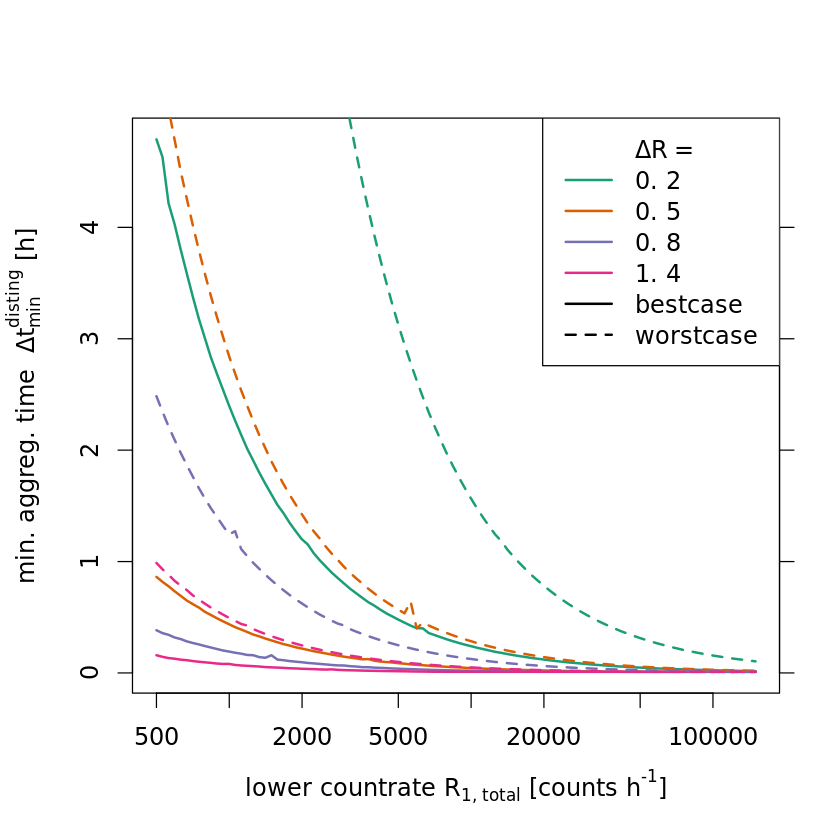

In [25]:

library(RColorBrewer)
palette(brewer.pal(n=nrow(collected_min_aggr_time), "Dark2")) #construct palette

# if (save_plots) x11(width=8, height=4)
# par(mar=par("mar") + c(0, 0.5,-3,0), cex=1.2, oma=c(0,0,0,0))
if (save_plots) x11()
par(mar=par("mar") + c(0, 0.5,0,0), cex=1.2)

scens2plot = names(results[["f2_2"]]) #get scenarios available in results
for (scen2plot in scens2plot)
{
  collected_min_aggr_time = results[["f2_2"]][[scen2plot]]
  matplot(R_fine, y= t(collected_min_aggr_time), type="l", log="x",
        xlab=TeX("lower countrate R_{1,total} \\[counts h^{-1}\\]"), 
        ylab=TeX("min. aggreg. time $ $ $ \\Delta t_{min}^{disting}$ \\[h\\]"),
        col=1:4, lwd=2,
        lty=linetypes[scen2plot],
        add=ifelse(scen2plot == scens2plot[1], FALSE, TRUE)
  )
}        


#text(x = exp(mean(log(range(R_fine)))), y=0.9 * max(collected_min_aggr_time), labels = paste0("\"", scenario, "\""), cex = 1.2)

axis(side=4, labels=FALSE)
legend_str = sapply(FUN = TeX, X =  c("$\\Delta R$=", paste0(contrasts_coarse, "")))
legend_str = c(legend_str, scens2plot)
legend("topright", legend=legend_str, 
       col=c(NA, palette()[ 1:length(contrasts_coarse)], rep("black", length(scens2plot))),
       lty=c(NA, rep("solid", length(contrasts_coarse)), linetypes[scens2plot]), lwd=2
)
savePlot2(filename = paste0("A2_p_R_vs_aggrtime_", scenario,".png"), type = "png")

if (Sys.info()["sysname"]=="Windows") #pdf-export only works in Windows
  savePlot2(filename = paste0("A2_p_R_vs_aggrtime_", scenario,".pdf"), type = "pdf")


Minimum aggregation time $\Delta t_\text{min}^{\text{disting}}$ required to statistically separate the reconstructed count rates  ${R}_\text{1r}$ and ${R}_\text{2r}$ from the two directional measurements with p-value < 0.05.

## 3.1 simulate  for a range of settings: R vs. contrasts (CI-thresh) ####

In [26]:

# requires functions p_value_two_sided() and compute_ci_p2()

# find the minimum required contrast for the CI to fall below specified precision
find_max_contrast = function(R_1, delta_t,  B,  Bi, target_sensor, precision) 
{  
  res = optimize(interval = c(0.0, 10), difference_to_threshold_ci, R_1=R_1, delta_t=delta_t, B=B, Bi=Bi, target_sensor, precision)
  
  #optimize(interval = range(contrasts_coarse), difference_to_threshold_ci, R_1=2000, R_2=2000+100, B=B, Bi=Bi, target_sensor, precision)
  if (res$objective > precision/100) res$minimum = NA #if the requested precision cannot be reached, return NA
  
  return(res$minimum)
}
#max contrast allowed for example setting 
#find_max_contrast(delta_t=0.1, R_1 = R_1, B=B, Bi=Bi, target_sensor="R_1r_t", precision=precision) #test


collected_max_contrast = array(NA, dim=c(length(delta_ts_coarse), length(R_fine)))

for (i in 1:length(delta_ts_coarse))
{
  delta_t = delta_ts_coarse[i]
  collected_max_contrast[i,] = sapply(X=R_fine, FUN=find_max_contrast, delta_t=delta_t, B=B, Bi=Bi, target_sensor="R_1r_t", precision=precision, simplify = TRUE)
}

#store results for displaying both scenarios when run again
results[["f3_1"]][scenario]=list(collected_max_contrast)

## 3.1 plot results (fig. 11)####

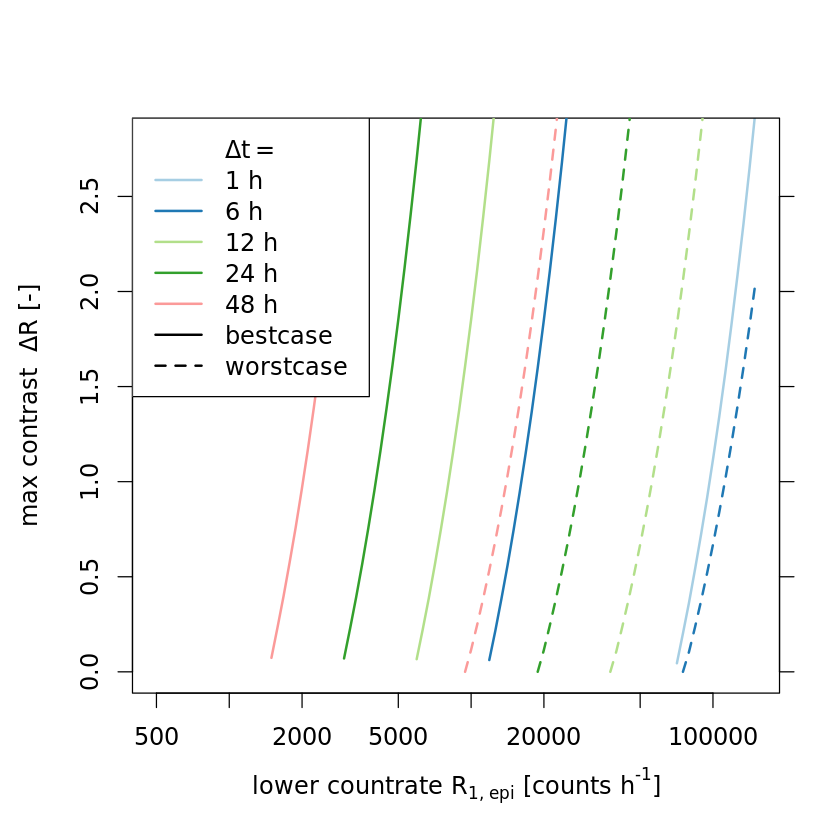

In [27]:

library(RColorBrewer)
palette(brewer.pal(n=nrow(collected_max_contrast), "Paired")) #construct palette

if (save_plots) x11()
par(mar=par("mar") + c(0, 0.5,0,0), cex=1.2)
options(scipen=5) #prevent scientific notation in log-scale of plot
ylims=c(0, 2*max(contrasts_coarse))

scens2plot = names(results[["f3_1"]]) #get scenarios available in results
for (scen2plot in scens2plot)
{
  collected_max_contrast = results[["f3_1"]][[scen2plot]]
  matplot(R_fine, y= t(collected_max_contrast), type="l",
        xlab=TeX("lower countrate R_{1,epi} \\[counts h^{-1}\\]"), 
        ylab=TeX("max contrast $ $ $\\Delta R$ \\[-\\]"),
        ylim=ylims,
        col=1:length(delta_ts_coarse), lwd=2, log="x",
        lty=linetypes[scen2plot],
        add=ifelse(scen2plot == scens2plot[1], FALSE, TRUE)
)
}        

#text(x = exp(mean(log(range(R_fine)))), y=0.9 * max(ylims), labels = paste0("\"", scenario, "\""), cex = 1.2)

axis(side=4, labels=FALSE)
legend_str = sapply(FUN = TeX, X =  c("$\\Delta t$=", paste0(delta_ts_coarse, " h")))
legend_str = c(legend_str, scens2plot)
legend("topleft", legend=legend_str, 
       col=c(NA, palette()[ 1:length(delta_ts_coarse)], rep("black", length(scens2plot))),
       bg = "white",
       lty=c(NA, rep("solid", length(delta_ts_coarse)), linetypes[scens2plot]), lwd=2
)
savePlot2(filename = paste0("B1_ci_R_vs_contrast_", scenario,".png"), type = "png")
if (Sys.info()["sysname"]=="Windows") #pdf-export only works in Windows
  savePlot2(filename = paste0("B1_ci_R_vs_contrast_", scenario,".pdf"), type = "pdf")


Maximum possible contrast $\Delta R$ in reconstructing the count rates ${R}_\text{1r}$ from the two directional measurements with a CI smaller than 5 \% of the true value.

## 3.2 simulate  for a range of settings: R vs. contrasts (p-thresh) ####

In [28]:

# requires functions p_value_two_sided() and compute_ci_p()

# find the minimum required aggregation time for the p-value to fall below specified p_thresh
find_min_contrast = function(R_1, delta_t,  B,  Bi, target_comparison, p_thresh) 
{  
  res = optimize(interval = c(0.001, 100), difference_to_threshold_p, R_1=R_1, delta_t=delta_t, B=B, Bi=Bi, target_comparison, p_thresh)
  if (res$objective > p_thresh/100) res$minimum = NA #if the requested p_value cannot be reached, return NA
  
  return(res$minimum)
}
# R_1=5000
# con=0.1
# #delta_t=9
# delta_t=6.350596
# 
# (con = find_min_contrast (R_1, delta_t,  B,  Bi, target_comparison="N_1r_epi.N_2r_epi", p_thresh) )
# difference_to_threshold_p(delta_t, R_1, con,  B,  Bi,  target_comparison="N_1r_epi.N_2r_epi", p_thresh) 
# compute_ci_p2(delta_t = delta_t, R_1=R_1, R_2=R_1*(1+con), B=B, Bi=Bi, eps=eps)  


collected_min_contrast = array(NA, dim=c(length(delta_ts_coarse), length(R_fine)))

for (i in 1:length(delta_ts_coarse))
{
  delta_t = delta_ts_coarse[i]
  collected_min_contrast[i,] = sapply(X=R_fine, FUN=find_min_contrast, delta_t=delta_t, B=B, Bi=Bi, target_comparison="N_1r_t.N_2r_t", p_thresh=p_thresh, simplify = TRUE)
}
#store results for displaying both scenarios when run again
results[["f3_2"]][scenario]=list(collected_min_contrast)

#find_min_contrast (R_1, delta_t,  B,  Bi, target_comparison="N_1r_t.N_2r_t", p_thresh) 


## 3.2 plot results (fig. 12)####

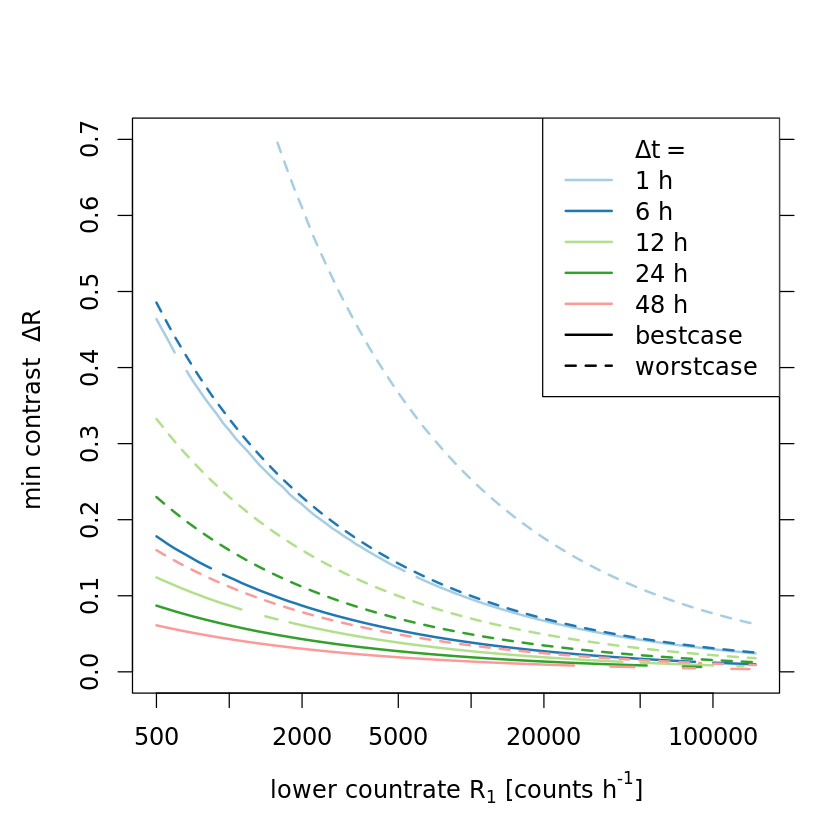

In [29]:

library(RColorBrewer)
palette(brewer.pal(n=nrow(collected_min_contrast), "Paired")) #construct palette

if (save_plots) x11()
par(mar=par("mar") + c(0, 0.5,0,0), cex=1.2)
ylims = c(0, 0.5*max(contrasts_coarse))
scens2plot = names(results[["f3_2"]]) #get scenarios available in results
for (scen2plot in scens2plot)
{
  collected_min_contrast = results[["f3_2"]][[scen2plot]]
  matplot(R_fine, y= t(collected_min_contrast), type="l",
        xlab=TeX("lower countrate R_{1} \\[counts h^{-1}\\]"), 
        ylab=TeX("min contrast $ $ $\\Delta R$ [-]"),
        col=1:length(delta_ts_coarse), lwd=2 , log="x",
        ylim=ylims,
        lty=linetypes[scen2plot],
        add=ifelse(scen2plot == scens2plot[1], FALSE, TRUE)
        )
}

#text(x = exp(mean(log(range(R_fine)))), y=0.9 * max(ylims), labels = paste0("\"", scenario, "\""), cex = 1.2)

axis(side=4, labels=FALSE)
legend_str = sapply(FUN = TeX, X =  c("$\\Delta t$=", paste0(delta_ts_coarse, " h")))
legend_str = c(legend_str, scens2plot)
legend("topright", legend=legend_str, 
       col=c(NA, palette()[ 1:length(delta_ts_coarse)], rep("black", length(scens2plot))),
       lty=c(NA, rep("solid", length(delta_ts_coarse)), linetypes[scens2plot]), lwd=2
       )
savePlot2(filename = paste0("B2_p_R_vs_contrast_", scenario,".png"), type = "png")
if (Sys.info()["sysname"]=="Windows") #pdf-export only works in Windows
  savePlot2(filename = paste0("B2_p_R_vs_contrast_", scenario,".pdf"), type = "pdf")



Minimum contrast $\Delta R$ required to statistically separate the reconstructed count rates  ${R}_\text{1r}$ and ${R}_\text{2r}$ from the two directional measurements with p-value < 0.05.

## 4.1 simulate  for a range of settings: aggr_time vs. contrasts (CI-thresh) ####

In [30]:

# requires functions p_value_two_sided() and compute_ci_p2()

# find the minimum required aggregation time for the CI to fall below specified precision
delta_ts_fine2 = exp(seq(from=log(min(delta_ts_coarse)), to=log(2*max(delta_ts_coarse)), length.out=200))  #aggregation intervals to test [h]
#here, we need some finer resolution to produce continuous lines


find_max_contrast = function(R_1, delta_t,  B,  Bi, target_sensor, precision) 
{  
  res = optimize(interval = c(0, 15), difference_to_threshold_ci, delta_t=delta_t, R_1=R_1, B=B, Bi=Bi, target_sensor=target_sensor, precision=precision)
  
  if (res$objective > precision/100) res$minimum = NA #if the requested precision cannot be reached, return NA
  
  return(res$minimum)
}
#find_max_contrast(delta_t = 1, R_1 = R_coarse[1], B=B, Bi=Bi, target_sensor="R_1r_t", precision=precision) #test


#required rate for 24 h and low contrast
optimize(interval = range(R_coarse), difference_to_threshold_ci, delta_t=24, contrast=min(contrasts_coarse), B=B, Bi=Bi, target_sensor="R_1r_t", precision=precision)
#required rate for 24 h and high contrast
optimize(interval = range(R_coarse), difference_to_threshold_ci, delta_t=24, contrast=max(contrasts_coarse), B=B, Bi=Bi, target_sensor="R_1r_t", precision=precision)




collected_max_contrast =array(NA, dim=c(length(R_coarse), length(delta_ts_fine2)))

for (i in 1:length(R_coarse))
{
  R_1 = R_coarse[i]
  collected_max_contrast[i,] = sapply(X=delta_ts_fine2, FUN=find_max_contrast, R_1=R_1, B=B, Bi=Bi, target_sensor="R_1r_t", precision=precision, simplify = TRUE)
}

#store results for displaying both scenarios when run again
results[["f4_1"]][scenario]=list(collected_max_contrast)


$minimum
[1] 20759

$objective
           R_1r_t 
0.000000004048873

$minimum
[1] 31615.4

$objective
          R_1r_t 
0.00000004602325

## 4.1 plot results (fig. 13)####

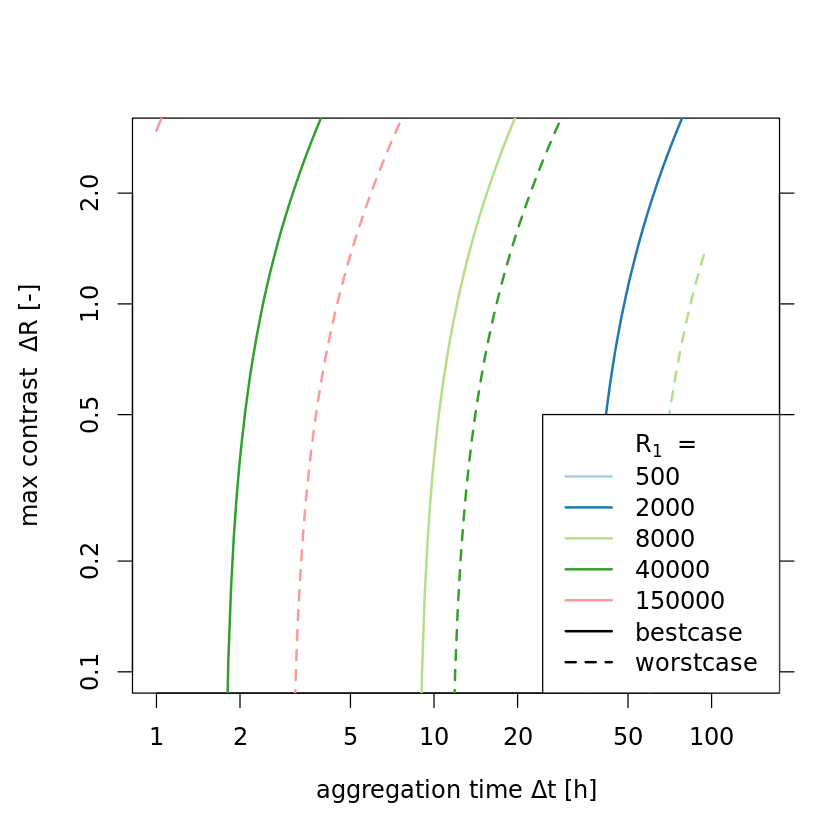

In [31]:

library(RColorBrewer)
palette(brewer.pal(n=nrow(collected_max_contrast), "Paired")) #construct palette

if (save_plots) x11()
par(mar=par("mar") + c(0, 0.5,0,0), cex=1.2)
options(scipen=5) #prevent scientific notation in log-scale of plot
ylims = c(0.5*min(contrasts_coarse), 2*max(contrasts_coarse))
xlims = c(min(delta_ts_fine2), 1.5*max(delta_ts_fine2))

scens2plot = names(results[["f4_1"]]) #get scenarios available in results
for (scen2plot in scens2plot)
{
  collected_max_contrast = results[["f4_1"]][[scen2plot]]
  matplot(delta_ts_fine2, y= t(collected_max_contrast), type="l",
        xlab=TeX("aggregation time  $\\Delta t$ \\[h\\]"),
        ylab=TeX("max contrast $ $ $\\Delta R$ \\[-\\]"),
        col=1:length(R_coarse), lwd=2, log="xy",
        xlim=xlims,
        ylim=ylims,
        lty=linetypes[scen2plot],
        add=ifelse(scen2plot == scens2plot[1], FALSE, TRUE)
  )
}

#text(x = exp(mean(log(range(delta_ts_fine2)))), y=0.9 * max(ylims), labels = paste0("\"", scenario, "\""), cex = 1.2)
axis(side=4, labels=FALSE)
legend_str = sapply(FUN = TeX, X =  c("R_1 [counts/h]=", paste0(R_coarse, "")))
legend_str = c(legend_str, scens2plot)
legend("bottomright", legend=legend_str, 
       col=c(NA, palette()[ 1:length(R_coarse)], rep("black", length(scens2plot))),
       lty=c(NA, rep("solid", length(R_coarse)), linetypes[scens2plot]), 
       lwd=2, bg = "white")

savePlot2(filename = paste0("C1_ci_aggrtime_vs_contrast_", scenario,".png"), type = "png")
if (Sys.info()["sysname"]=="Windows") #pdf-export only works in Windows
  savePlot2(filename = paste0("C1_ci_aggrtime_vs_contrast_", scenario,".pdf"), type = "pdf")


Maximum possible contrast $\Delta R$ to allow the reconstruction of the count rate ${R}_\text{1r}$ from the two directional measurements with a CI smaller than 5 \% of the true value with the aggregation time $\Delta t$.

## 4.2 simulate  for a range of settings: R vs. contrasts (p-thresh) ####

In [32]:

# requires functions p_value_two_sided() and compute_ci_p()

# find the minimum required contrast for the p-value to fall below specified p_thresh
find_min_contrast = function(R_1, delta_t,  B,  Bi, target_comparison, p_thresh) 
{  
  res = optimize(interval = c(0.001, 10), difference_to_threshold_p, R_1=R_1, delta_t=delta_t, B=B, Bi=Bi, target_comparison, p_thresh)
  return(res$minimum)
}


collected_min_contrast = array(NA, dim=c(length(R_coarse), length(delta_ts_fine)))

for (i in 1:length(R_coarse))
{
  R_1 = R_coarse[i]
  collected_min_contrast[i,] = sapply(X=delta_ts_fine, FUN=find_min_contrast, R_1=R_1, B=B, Bi=Bi, target_comparison="N_1r_t.N_2r_t", p_thresh=p_thresh, simplify = TRUE)
}

#store results for displaying both scenarios when run again
results[["f4_2"]][scenario]=list(collected_min_contrast)


#find_min_contrast(delta_ts_fine[i], R_1=R_1, B=B, Bi=Bi, target_comparison="N_1r_t.N_2r_t", p_thresh=p_thresh)


#min required rate for 1 h and low contrast
optimize(interval = c(1,100000), difference_to_threshold_p, delta_t=1, contrast=min(contrasts_coarse), B=B, Bi=Bi, target_comparison="N_1r_t.N_2r_t", p_thresh=p_thresh)
#required rate for 1 h and high contrast
optimize(interval = c(1,100000), difference_to_threshold_p, delta_t=1, contrast=max(contrasts_coarse), B=B, Bi=Bi, target_comparison="N_1r_t.N_2r_t", p_thresh=p_thresh)
#required rate for 1 h and contrast 0.4
optimize(interval = c(1,100000), difference_to_threshold_p, delta_t=1, contrast=0.4, B=B, Bi=Bi, target_comparison="N_1r_t.N_2r_t", p_thresh=p_thresh)



$minimum
[1] 15636.58

$objective
 N_1r_t.N_2r_t 
0.000002817892

$minimum
[1] 493.5844

$objective
N_1r_t.N_2r_t 
0.00005537621

$minimum
[1] 4271.622

$objective
N_1r_t.N_2r_t 
 0.0001243353

## 4.2 plot results (fig. 14)####

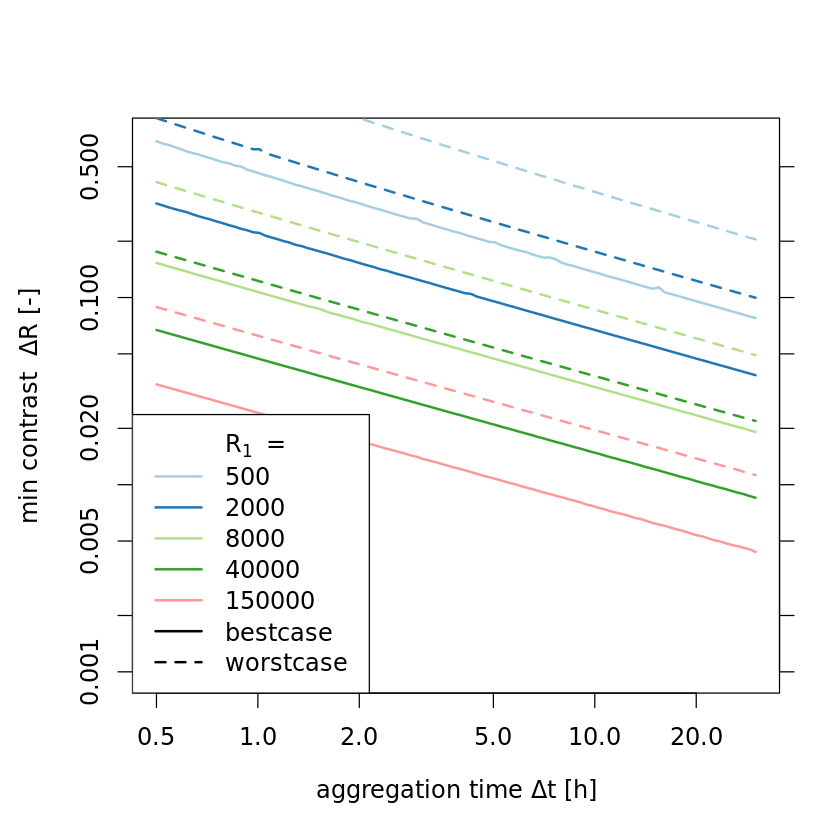

In [33]:

library(RColorBrewer)
palette(brewer.pal(n=nrow(collected_min_contrast), "Paired")) #construct palette

if (save_plots) x11()
par(mar=par("mar") + c(0, 0.5,0,0), cex=1.2)
options(scipen=5) #prevent scientific notation in log-scale of plot
ylims = c(1e-3, 0.5*max(contrasts_coarse))

scens2plot = names(results[["f4_2"]]) #get scenarios available in results
for (scen2plot in scens2plot)
{
  collected_min_contrast = results[["f4_2"]][[scen2plot]]
  matplot(delta_ts_fine, y= t(collected_min_contrast), type="l",
        xlab=TeX("aggregation time  $\\Delta t$ \\[h\\]"),
        ylab=TeX("min contrast $ $ $\\Delta R$ \\[-\\]"),
        ylim=ylims,
        col=1:length(R_coarse), lwd=2, log="xy",
        lty=linetypes[scen2plot],
        add=ifelse(scen2plot == scens2plot[1], FALSE, TRUE)
)
}

#text(x = exp(mean(log(range(delta_ts_fine)))), y=0.9 * max(ylims), labels = paste0("\"", scenario, "\""), cex = 1.2)

axis(side=4, labels=FALSE)
legend_str = sapply(FUN = TeX, X =  c("R_1 [counts/h]=", paste0(R_coarse, "")))
legend_str = c(legend_str, scens2plot)
legend("bottomleft", legend=legend_str, 
              col=c(NA, palette()[ 1:length(R_coarse)], rep("black", length(scens2plot))),
       lty=c(NA, rep("solid", length(R_coarse)), linetypes[scens2plot]), 
       lwd=2, bg = "white")
savePlot2(filename = paste0("C2_p_aggrtime_vs_contrast_", scenario,".png"), type = "png")
if (Sys.info()["sysname"]=="Windows") #pdf-export only works in Windows
  savePlot2(filename = paste0("C2_p_aggrtime_vs_contrast_", scenario,".pdf"), type = "pdf")  

# convert this Rmd to ipynb by one of these
# /home/till/.local/bin/notedown directional_CRNS_demo.Rmd --knit > directional_CRNS_demo.ipynb
# /home/till/.local/bin/jupytext --to notebook directional_CRNS_demo.Rmd


Minimum contrast $\Delta {R}$ required to statistically separate the count rates  ${R}_\text{1r}$ and ${R}_\text{2r}$ reconstructed from the two directional measurements with a p-value < 0.05.